In [62]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
from sklearn.feature_selection import chi2
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, classification_report 
from sklearn.tree import DecisionTreeClassifier 
from sklearn.preprocessing import LabelEncoder, StandardScaler
import xgboost as xgb
import pickle as pkl
from sklearn.model_selection import cross_val_score, GridSearchCV
from imblearn.over_sampling import SMOTE
import warnings

In [63]:
df = pd.read_csv('Train.csv')

In [64]:
df

,S.No.,datetime,temperature,humidity,fanSpeed
0,1,01/04/2021 0:01,32,34,4
1,2,01/04/2021 0:01,32,35,4
2,3,01/04/2021 0:01,32,35,4
3,4,01/04/2021 0:02,32,35,4
4,5,01/04/2021 0:04,32,34,4
...,...,...,...,...,...
79379,79380,31/07/2021 9:54,32,92,4
79380,79381,31/07/2021 9:55,31,93,4
79381,79382,31/07/2021 9:55,32,92,4
79382,79383,31/07/2021 9:56,31,93,4


In [65]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79384 entries, 0 to 79383
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   S.No.        79384 non-null  int64 
 1   datetime     79384 non-null  object
 2   temperature  79384 non-null  int64 
 3   humidity     79384 non-null  int64 
 4   fanSpeed     79384 non-null  int64 
dtypes: int64(4), object(1)
memory usage: 3.0+ MB


In [66]:
print('Train data shape:', df.shape)

Train data shape: (79384, 5)


In [67]:
df_cleaned = df.drop(columns=['datetime','S.No.'])

In [68]:
df_cleaned 

,temperature,humidity,fanSpeed
0,32,34,4
1,32,35,4
2,32,35,4
3,32,35,4
4,32,34,4
...,...,...,...
79379,32,92,4
79380,31,93,4
79381,32,92,4
79382,31,93,4


## Handling Missing Values


In [69]:
df_cleaned.isnull().sum()

temperature    0
humidity       0
fanSpeed       0
dtype: int64

In [70]:
df_cleaned.isnull().any()

temperature    False
humidity       False
fanSpeed       False
dtype: bool

In [71]:
print(df_cleaned['fanSpeed'].value_counts())

fanSpeed
4    61989
5    10146
3     5495
8     1521
1      122
6       78
2       21
7        8
0        4
Name: count, dtype: int64


#### There seems to be no need to handle missing values since there seems to be no null, missing or duplicated values

In [72]:
df_test = pd.read_csv('Testt.csv')

In [73]:
df_test

,S.No.,datetime,temperature,humidity,mode,speed,opTime,eSpent,eSaved,fanSpeed
0,0,10/11/2020 11:42,25,48,0,0,0,0,0,8
1,1,10/11/2020 11:42,25,48,0,0,0,0,0,8
2,2,11/11/2020 20:18,30,29,0,5,31,1488,1488,3
3,3,11/11/2020 20:18,30,25,0,2,31,465,589,8
4,4,11/11/2020 20:19,30,29,0,3,148,2960,5180,3
...,...,...,...,...,...,...,...,...,...,...
110404,110404,15/04/2022 16:31,35,31,0,5,31,1488,1488,8
110405,110405,15/04/2022 16:31,36,32,0,5,1241,59568,59568,8
110406,110406,15/04/2022 16:52,36,33,0,3,93,1860,3255,8
110407,110407,15/04/2022 16:54,35,33,0,3,93,1860,3255,8


# Exploratory Data Analysis

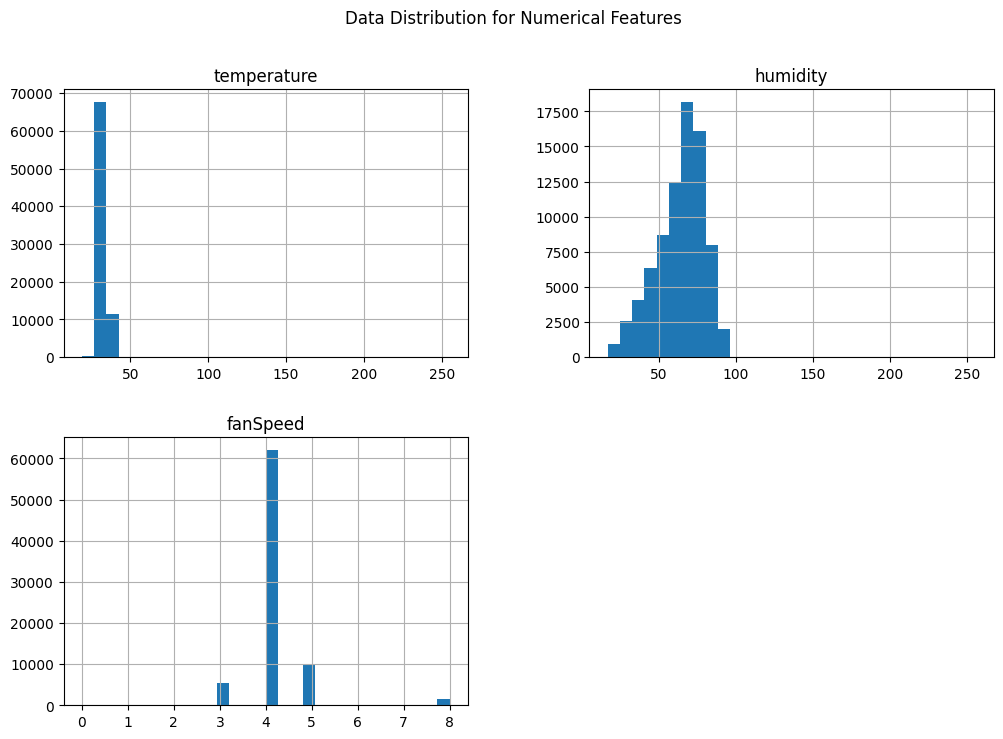

In [74]:
df_cleaned.hist(figsize=(12, 8), bins=30)
plt.suptitle("Data Distribution for Numerical Features")
plt.show()

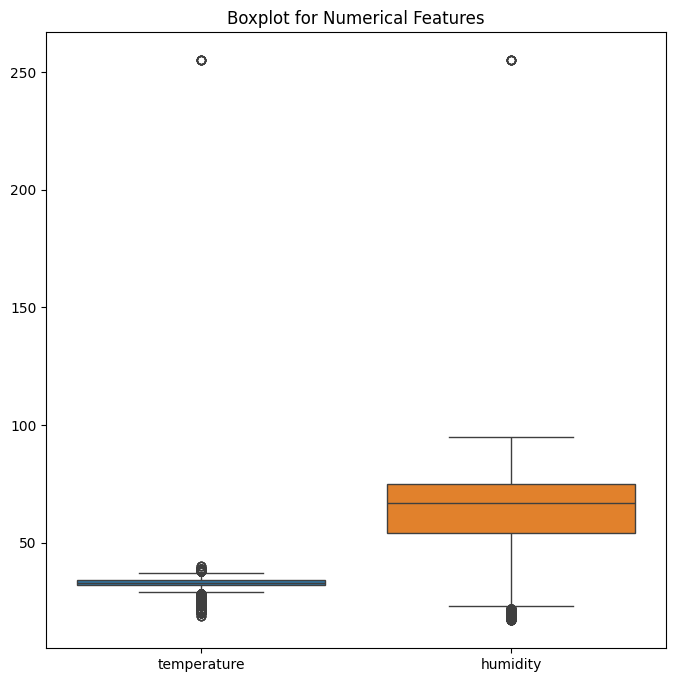

In [75]:
plt.figure(figsize=(8, 8))
sns.boxplot(data=df_cleaned[['temperature', 'humidity']])
plt.title("Boxplot for Numerical Features")
plt.show()

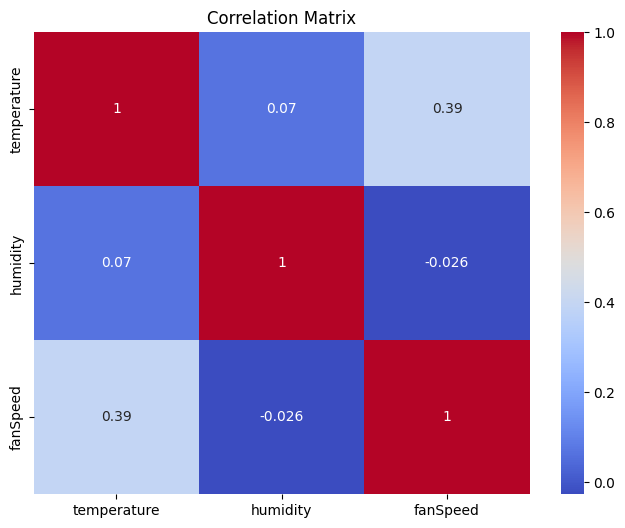

In [76]:
plt.figure(figsize=(8, 6))
corr_matrix = df_cleaned.corr()
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()

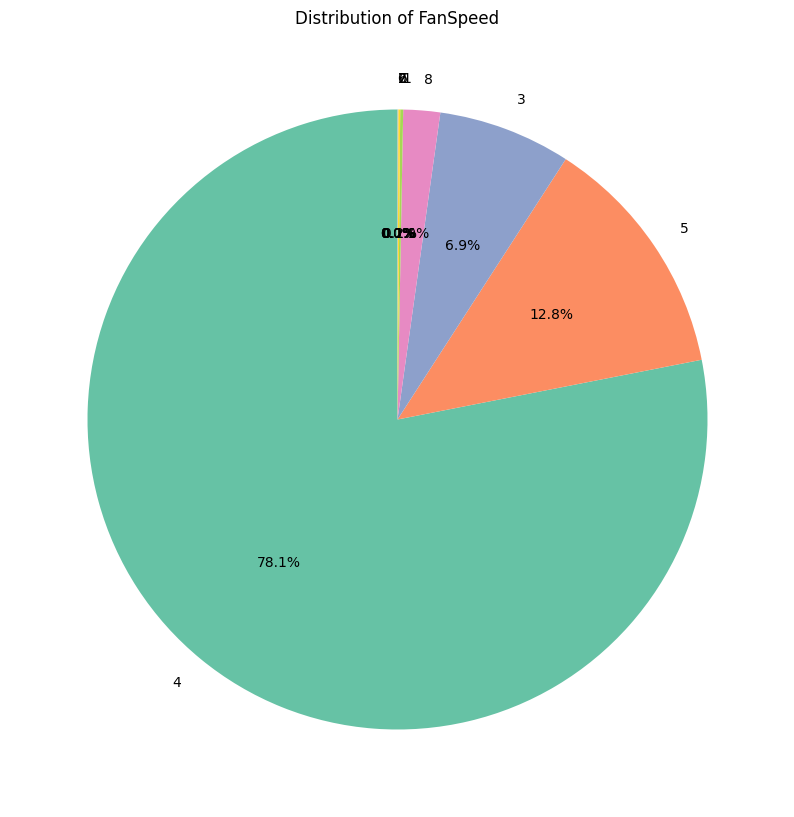

In [77]:
fan_speed_counts = df_cleaned['fanSpeed'].value_counts()

plt.figure(figsize=(10, 12))
plt.pie(fan_speed_counts, labels=fan_speed_counts.index, autopct='%1.1f%%', startangle=90, colors=sns.color_palette('Set2'))
plt.title('Distribution of FanSpeed')
plt.show()

## Undersampling the data

In [78]:
from sklearn.utils import resample

X = df_cleaned[['temperature', 'humidity']]
y = df_cleaned['fanSpeed']

df_combined = pd.concat([X, y], axis=1)

df_majority = df_combined[df_combined['fanSpeed'] == df_combined['fanSpeed'].mode()[0]]
df_minority = df_combined[df_combined['fanSpeed'] != df_combined['fanSpeed'].mode()[0]]

# Undersample the majority class
df_majority_undersampled = resample(df_majority, replace=False, n_samples=len(df_minority), random_state=42) 
df_majority_undersampled

,temperature,humidity,fanSpeed
29255,32,67,4
28732,33,63,4
26474,34,61,4
42379,33,72,4
50698,34,72,4
...,...,...,...
11266,33,73,4
20961,34,40,4
24463,34,55,4
60869,33,81,4


In [79]:
df_undersampled = pd.concat([df_majority_undersampled, df_minority])

X_undersampled = df_undersampled[['temperature', 'humidity']]
y_undersampled = df_undersampled['fanSpeed']

print(f'Original dataset shape: {df_combined.shape}')
print(f'Undersampled dataset shape: {df_undersampled.shape}')

Original dataset shape: (79384, 3)
Undersampled dataset shape: (34790, 3)


## Model Building

In [80]:
X_undersampled = df_undersampled[['temperature', 'humidity']]
y_undersampled = df_undersampled['fanSpeed']

rf_model = RandomForestClassifier(random_state=42)
dt_model = DecisionTreeClassifier(random_state=42)
knn_model = KNeighborsClassifier()
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')

rf_model.fit(X_undersampled, y_undersampled)
dt_model.fit(X_undersampled, y_undersampled)
knn_model.fit(X_undersampled, y_undersampled)
xgb_model.fit(X_undersampled, y_undersampled)

print("Models have been trained successfully.")

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [12:24:59] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Models have been trained successfully.


In [81]:
from sklearn.metrics import accuracy_score
df_test = pd.read_csv('Test.csv')  # Replace with your actual test dataset file path
X_test = df_test[['temperature', 'humidity']]
y_test = df_test['fanSpeed']
models = {
    'Random Forest': rf_model,
    'Decision Tree': dt_model,
    'k-NN': knn_model,
    'XGBoost': xgb_model
}

for name, model in models.items():
    print(f'---->{name.upper()}<----')
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    print(f'Confusion Matrix for {name}:\n{cm}\n')
    print(f'Classification Report for {name}:\n{classification_report(y_test, y_pred)}')
    accuracy = accuracy_score(y_test, y_pred)
    print(f'{name} Accuracy: {accuracy:.2f}\n')

---->RANDOM FOREST<----
Confusion Matrix for Random Forest:
[[ 1052     0     0     0     0     0     0     0]
 [    1     6     0     0     0     0     0     0]
 [    0     0 21864     0     0     0     0     0]
 [    0     0     0 45971     0     0     0     0]
 [    0     0     0     0  3076     0     0     0]
 [    0     0     0     0     0   917     0   899]
 [    0     0     0     0     0     0     2     3]
 [    1     0  2219   143     0   226     0 34029]]

Classification Report for Random Forest:
              precision    recall  f1-score   support

           1       1.00      1.00      1.00      1052
           2       1.00      0.86      0.92         7
           3       0.91      1.00      0.95     21864
           4       1.00      1.00      1.00     45971
           5       1.00      1.00      1.00      3076
           6       0.80      0.50      0.62      1816
           7       1.00      0.40      0.57         5
           8       0.97      0.93      0.95     36618

 

In [50]:
from sklearn.metrics import accuracy_score
df_test = pd.read_csv('Train.csv')  # Replace with your actual test dataset file path
X_test = df_test[['temperature', 'humidity']]
y_test = df_test['fanSpeed']
models = {
    'Random Forest': rf_model,
    'Decision Tree': dt_model,
    'k-NN': knn_model,
    'XGBoost': xgb_model
}

for name, model in models.items():
    print(f'---->{name.upper()}<----')
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    print(f'Confusion Matrix for {name}:\n{cm}\n')
    print(f'Classification Report for {name}:\n{classification_report(y_test, y_pred)}')
    accuracy = accuracy_score(y_test, y_pred)
    print(f'{name} Accuracy: {accuracy:.2f}\n')


---->RANDOM FOREST<----
Confusion Matrix for Random Forest:
[[    4     0     0     0     0     0     0     0     0]
 [    0   122     0     0     0     0     0     0     0]
 [    0     0    21     0     0     0     0     0     0]
 [    0     0     0  5495     0     0     0     0     0]
 [    0     0     0     0 61989     0     0     0     0]
 [    0     0     0     0     0 10146     0     0     0]
 [    0     0     0     0     0     0    78     0     0]
 [    0     0     0     0     0     0     0     8     0]
 [    0     0     0     0     0     0     0     0  1521]]

Classification Report for Random Forest:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       1.00      1.00      1.00       122
           2       1.00      1.00      1.00        21
           3       1.00      1.00      1.00      5495
           4       1.00      1.00      1.00     61989
           5       1.00      1.00      1.00     10146
     

In [51]:
import pandas as pd
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import make_scorer, mean_squared_error

# Load the datasets
train_data = pd.read_csv('Train.csv')

# Define features and target for training
X_train = train_data[['temperature', 'humidity']]
y_train = train_data['fanSpeed']

# Initialize the model
model = DecisionTreeRegressor()

# Perform cross-validation
# Using 'neg_mean_squared_error' as scoring for regression
scores = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')

# Convert negative MSE to positive MSE
scores = -scores

print("Cross-validation scores (MSE):", scores)
print("Mean MSE:", scores.mean())
print("Standard deviation:", scores.std())


Cross-validation scores (MSE): [0.00226743 0.00308623 0.00201549 0.00025194 0.        ]
Mean MSE: 0.0015242174214272217
Standard deviation: 0.0011979586499181196


In [23]:
from sklearn.metrics import mean_squared_error

# Load the test dataset
test_data = pd.read_csv('Test.csv')

# Define features and target for testing
X_test = test_data[['temperature', 'humidity']]
y_test = test_data['fanSpeed']

# Train the model on the full training data
model.fit(X_train, y_train)

# Make predictions on the test data
y_pred = model.predict(X_test)

# Compute MSE on the test data
test_mse = mean_squared_error(y_test, y_pred)

print("Test Mean Squared Error (MSE):", test_mse)

Test Mean Squared Error (MSE): 0.6386979322337852


In [ ]:
import pickle
from sklearn.tree import DecisionTreeClassifier

# Example: Train a Decision Tree model
# Assume X_train and y_train are your training data
model = DecisionTreeClassifier()
model.fit(X_train, y_train)

# Save the model to a .pkl file
#with open('decision_tree_model.pkl', 'wb') as file:
   # pickle.dump(model, file)


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# Define the model architecture
model = Sequential([
    Dense(64, activation='relu', input_shape=(2,)),  # Assuming 2 features: temperature and humidity
    Dense(32, activation='relu'),
    Dense(1)  # Output layer for fanSpeed
])

model.compile(optimizer='adam', loss='mean_squared_error')

# Assuming X_train and y_train are your data
model.fit(X_train, y_train, epochs=10,batch_size = 16)

# Save the model in TensorFlow format
#model.save('model.h5')


In [ ]:
#import tensorflow as tf

# Load the TensorFlow model
#model = tf.keras.models.load_model('model.h5')

# Convert the model to TensorFlow Lite format
#converter = tf.lite.TFLiteConverter.from_keras_model(model)
#tflite_model = converter.convert()

# Save the TFLite model
#with open('model.tflite', 'wb') as f:
    #f.write(tflite_model)
